<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/finalProject/Recommendation_System_Project_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6>Recommendation Systems - Final Project</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

</div>

# Background/Introduction
TODO

# Main Objective<br>
In this project we are ... TODO

# Data

The Taste Profile Subset, provided by the Echo Nest as a component of the Million Song Dataset, comprises two files. The initial file includes song details such as ID, title, release information, artist name, and release year. The second file contains user IDs, song IDs, and the corresponding play counts by users.

`song_data.rar` - <br>

**song_id** - A unique id given to every song

**title** - Title of the song

**Release** - Name of the released album

**Artist_name** - Name of the artist

**year** - Year of release

<br>

`triplets_file.rar` - <br>

**user_id** - A unique id given to the user

**song_id** - A unique id given to the song

**play_count** - Number of times the song was played

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Background/Introduction](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=2PTur39mv9rt)

>[Main Objective](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=kaFLNJh5gnu7)

>[Data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=6KQAH9j-qoZw)

>[Import Libraries](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=kXwOL606ZfUN)

>[Handling the data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=10dFieGliGFn)

>>[Data cleaning](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=i1NGznkkiL5J)

>>[Merging the data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=HGCZ7ah8iOMa)

>[Exploratory Data Analysis](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=Wm5QD4lUigH8)

>[Preprocessing](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=8iVqCeAMimBE)

>[Full function section](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=y_4W_frl0COw)

>>[Splitting the data](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=m5SPLS-Ujixp)

>[Recommendation system workflow](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=ZkALY4u6kidY)

>[Algorithms and Models analysis](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=zHwULddKlZkf)

>>[Rank-based](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=T2_JBRavnciT)

>>[Collaborative-filtering](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=uZX1s5honcYg)

>>>[Similarity/Neighborhood-based](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=C-AdyyD6ncFC)

>>>[Model-based](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=6yDQucirnlkk)

>>[Cluster-based](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=ABABIeyTn0F5)

>>[Content-based](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=VrodWBIBn197)

>[Evaluation metrics](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=5lX4C4NzlmOK)

>[Showing predictions](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=taheIRbMoCLN)

>[Comparing the models](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=HJLFpdHpoRGe)

>[Final thoughts](#updateTitle=true&folderId=13--mVhc71hy_YO6feHv96bS47DWe0uh2&scrollTo=rzu6n94-onDL)



#  Import Libraries

In [1]:
!pip install rarfile

In [2]:
# Basic libraries of python for numeric and dataframe computations
import pandas as pd
import numpy as np

# Import Matplotlib the Basic library for data visualization
import matplotlib.pyplot as plt

# Import seaborn - Slightly advanced library for data visualization
import seaborn as sns

# Import the required library to compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# Import defaultdict from collections A dictionary output that does not raise a key error
from collections import defaultdict

# Import mean_squared_error : a performance metrics in sklearn
from sklearn.metrics import mean_squared_error

import rarfile
from io import BytesIO
import requests

# Custom colors
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [3]:
song_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/song_data.rar'
count_data_rar_url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/finalProject/Data/triplets_file.rar'

In [4]:
# Download the RAR files
song_data_rar_response = requests.get(song_data_rar_url)
count_data_rar_response = requests.get(count_data_rar_url)

In [5]:
def extract_csv_from_rar(rar_content):
    # Create a RarFile object from the content
    with rarfile.RarFile(BytesIO(rar_content), 'r') as rar_file:
        # Get list of files in the RAR archive
        file_list = rar_file.namelist()

        # Initialize empty DataFrames
        df = pd.DataFrame()

        # Iterate through each file in the archive
        for file_name in file_list:
            # Check if the file is a CSV file
            if file_name.endswith('.csv'):
                print(file_name)
                # Extract the CSV file and read it into a DataFrame
                with rar_file.open(file_name) as csv_file:
                    df = pd.read_csv(csv_file)

    return df

In [6]:
if song_data_rar_response.ok and count_data_rar_response.ok:
    # Extract content from the responses
    song_data_rar_content = song_data_rar_response.content
    count_data_rar_content = count_data_rar_response.content

    # Extract CSV files from RAR archives and convert to DataFrames
    song_df = extract_csv_from_rar(song_data_rar_content)
    count_df = extract_csv_from_rar(count_data_rar_content)
else:
  print("Error accessing the rar files, Try Again!")

song_data.csv
triplets_file.csv


In [7]:
song_df

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,SOTXAME12AB018F136,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,SOXQYIQ12A8C137FBB,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,SOHODZI12A8C137BB3,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,SOLXGOR12A81C21EB7,Faraday,The Trance Collection Vol. 2,Elude,0


In [8]:
count_df

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1


In [9]:
count_df.nunique()

user_id         76353
song_id         10000
listen_count      295
dtype: int64

# Handling the data

## Data cleaning

## Merging the data

In [10]:
# Merge count_df and song_df by song_id
combined_df = count_df.merge(song_df.drop_duplicates('song_id'), how='left', on='song_id').drop_duplicates()

In [11]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


# Exploratory Data Analysis

In [50]:
df = combined_df

In [57]:
#Checking Data Types
df.dtypes


user_id          int64
song_id          int64
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

In [58]:
#Summary Statistics
df.describe()

,user_id,song_id,listen_count,year
count,117876.000000,117876.000000,117876.000000,117876.000000
mean,37986.496954,4896.602608,1.700058,1652.819683
std,22041.887894,2916.276544,1.089517,761.726035
min,11.000000,21.000000,1.000000,0.000000
25%,19275.000000,2220.000000,1.000000,1994.000000
50%,37049.000000,5023.000000,1.000000,2005.000000
75%,57152.000000,7522.000000,2.000000,2008.000000
max,76347.000000,9989.000000,5.000000,2010.000000


In [59]:
#Missing Values
df.isnull().sum()


user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

In [60]:
#Unique Values
df.nunique()

user_id         3155
song_id          563
listen_count       5
title            561
release          369
artist_name      232
year              37
dtype: int64

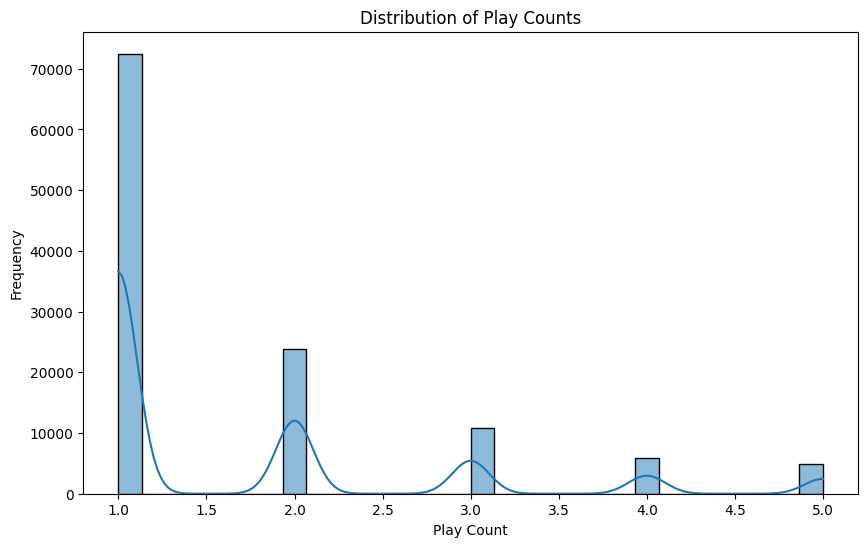

In [63]:
def plot_play_count_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['listen_count'], bins=30, kde=True)
    plt.title('Distribution of Play Counts')
    plt.xlabel('Play Count')
    plt.ylabel('Frequency')
    plt.show()

plot_play_count_distribution(df)


In [65]:
#Top Songs
def top_songs(df, n=10):
    return df.groupby('song_id')['listen_count'].sum().sort_values(ascending=False).head(n)

top_songs(df)

song_id
352     1634
2220    1583
8582    1463
5531    1427
4448    1291
4152    1259
1334    1208
1118    1203
8092    1126
6189    1067
Name: listen_count, dtype: int64

In [66]:

#Top Artists
def top_artists(df, n=10):
    return df.groupby('artist_name')['listen_count'].sum().sort_values(ascending=False).head(n)

top_artists(df)

artist_name
Coldplay                  9049
The Killers               6152
Florence + The Machine    5422
Kings Of Leon             4855
Justin Bieber             3496
the bird and the bee      3479
Vampire Weekend           3332
LCD Soundsystem           3283
Octopus Project           2881
Radiohead                 2753
Name: listen_count, dtype: int64

In [71]:
#Top Users
def top_users(df, n=10):
    return df.groupby('user_id')['listen_count'].sum().sort_values(ascending=False).head(n)

top_users(df)

user_id
3237     586
15733    479
62759    438
43041    417
27401    409
66268    403
23337    399
48844    397
19783    396
55266    387
Name: listen_count, dtype: int64

plotting #TODO

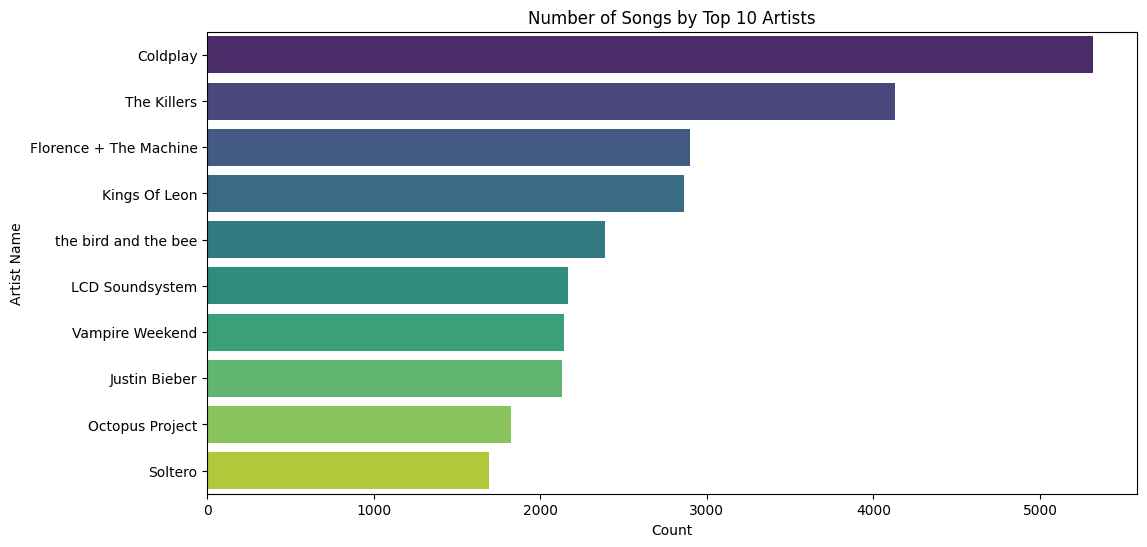

In [72]:

#Artist-wise Analysis
def artistwise_analysis(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(y='artist_name', data=df, palette='viridis', order=df['artist_name'].value_counts().index[:10])
    plt.title('Number of Songs by Top 10 Artists')
    plt.xlabel('Count')
    plt.ylabel('Artist Name')
    plt.show()

artistwise_analysis(df)

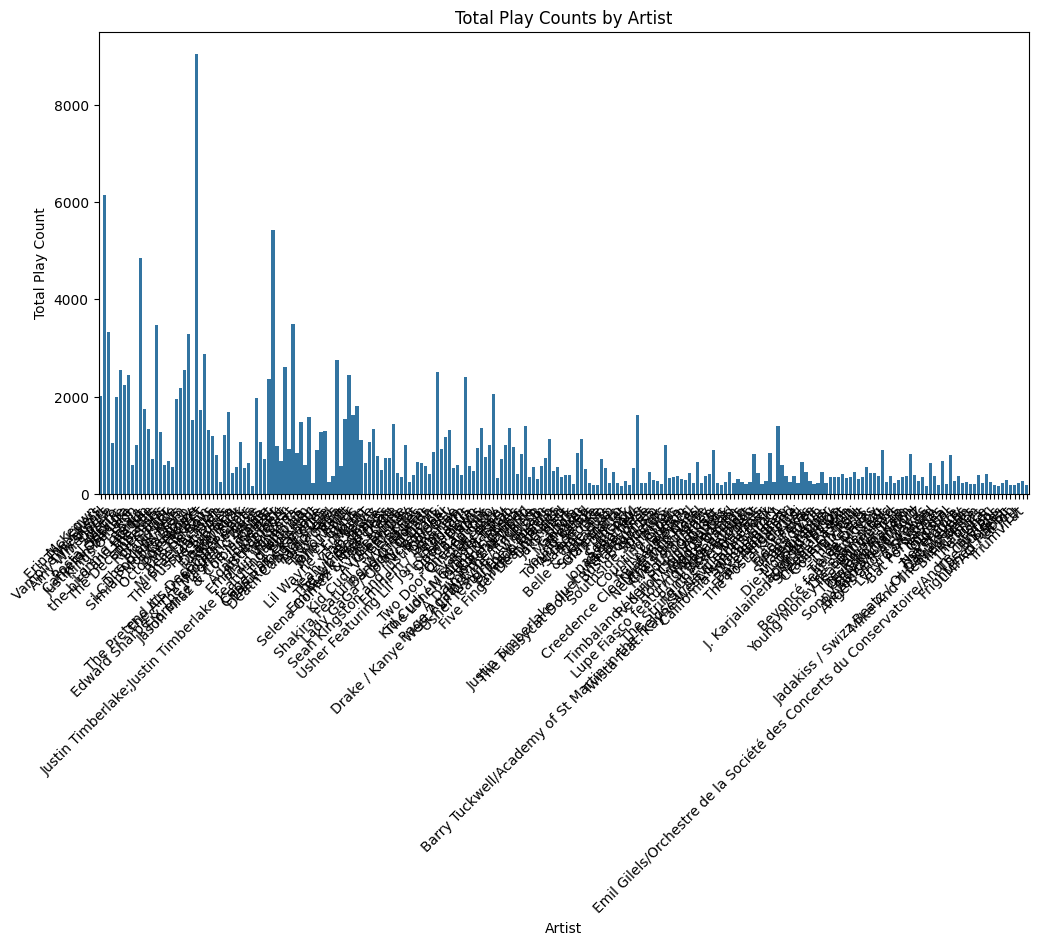

In [73]:
#Bar Plot of Play Counts by Artist
def plot_play_counts_by_artist(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='artist_name', y='listen_count', data=df, estimator=sum, ci=None)
    plt.xticks(rotation=45, ha='right')
    plt.title('Total Play Counts by Artist')
    plt.xlabel('Artist')
    plt.ylabel('Total Play Count')
    plt.show()

plot_play_counts_by_artist(df)
#TODO - MAYBE DELETE

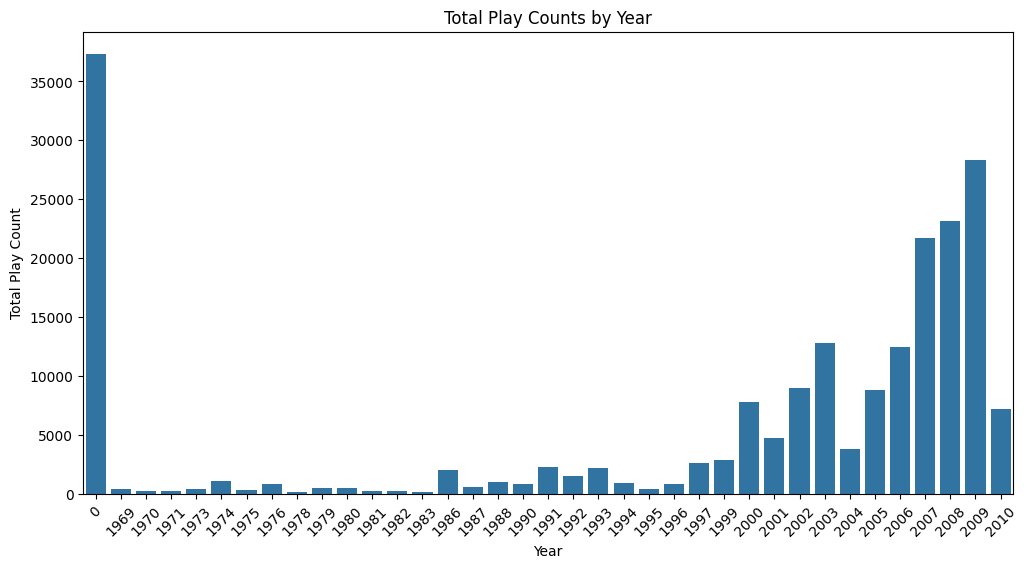

In [74]:

#Bar Plot of Play Counts by Year
def plot_play_counts_by_year(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='listen_count', data=df, estimator=sum, ci=None)
    plt.xticks(rotation=45)
    plt.title('Total Play Counts by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Play Count')
    plt.show()

plot_play_counts_by_year(df)

TODO
NEED TO HANGLE YEAR = 0

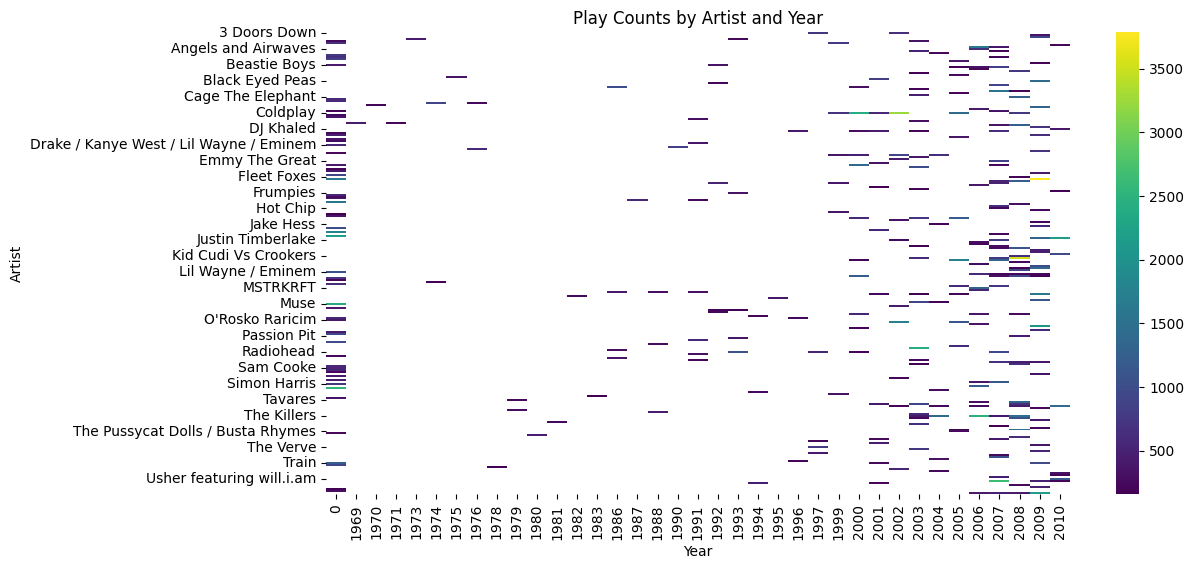

In [75]:

#Heatmap of Play Counts by Artist and Year
def plot_heatmap_play_counts(df):
    pivot = df.pivot_table(index='artist_name', columns='year', values='listen_count', aggfunc=sum)
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap='viridis')
    plt.title('Play Counts by Artist and Year')
    plt.xlabel('Year')
    plt.ylabel('Artist')
    plt.show()

plot_heatmap_play_counts(df)
#todo maybe delte

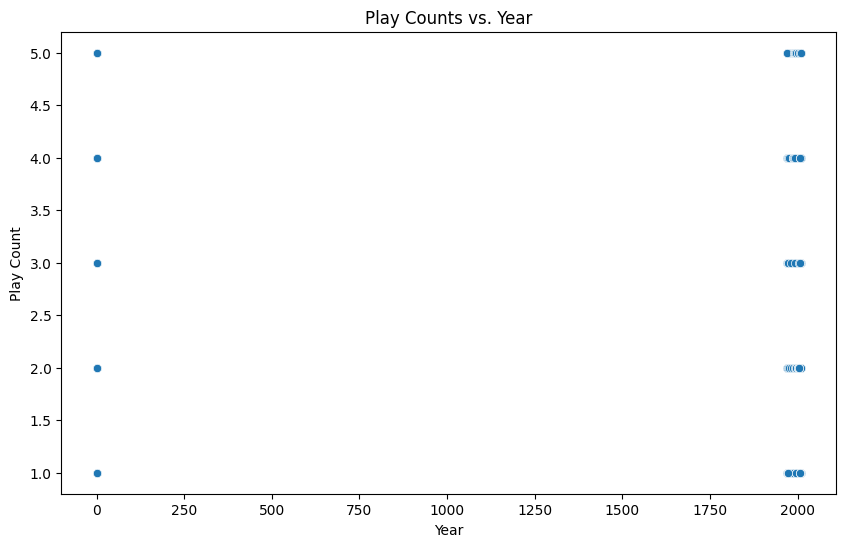

In [77]:
#Scatter Plot of Play Counts vs. Year
def plot_scatter_play_counts_vs_year(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='year', y='listen_count', data=df)
    plt.title('Play Counts vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Play Count')
    plt.show()

plot_scatter_play_counts_vs_year(df)
#todo maybe delete

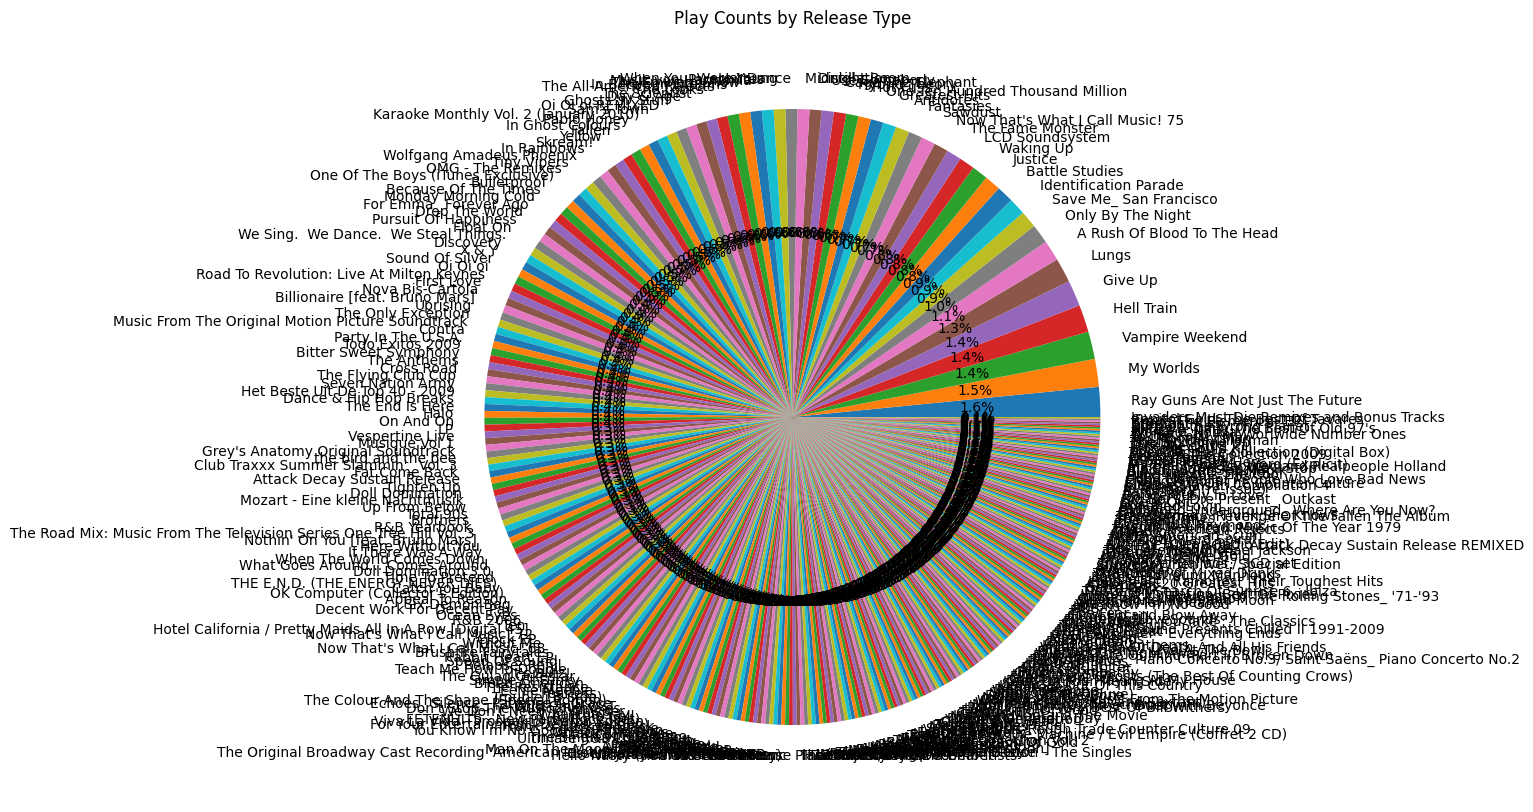

In [78]:
#Pie Chart of Play Counts by Release Type
def plot_pie_play_counts_by_release(df):
    release_counts = df['release'].value_counts()
    plt.figure(figsize=(10, 10))
    plt.pie(release_counts, labels=release_counts.index, autopct='%1.1f%%')
    plt.title('Play Counts by Release Type')
    plt.show()

plot_pie_play_counts_by_release(df)

#todo - another pie

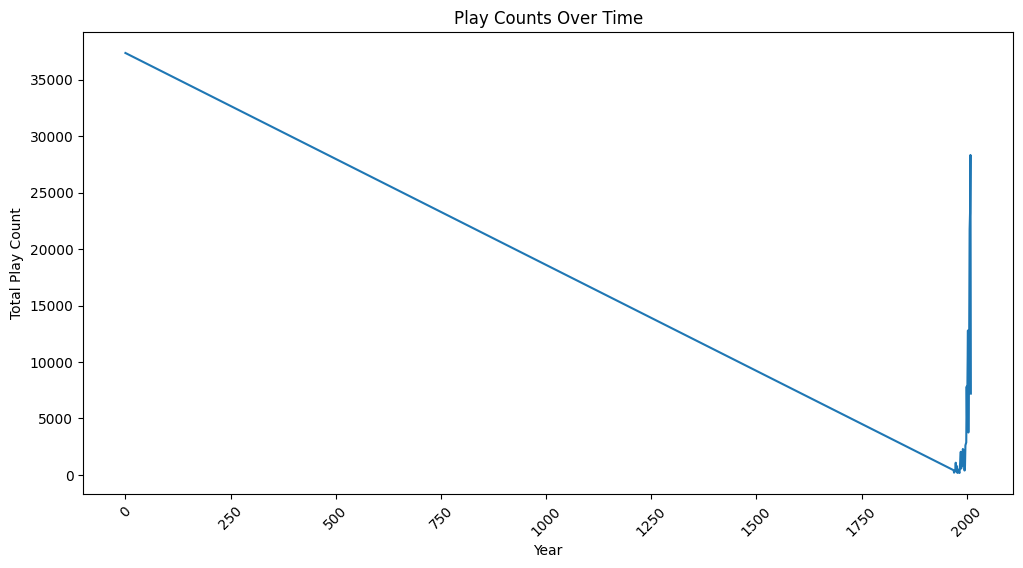

In [79]:
#Line Plot of Play Counts Over Time
def plot_line_play_counts_over_time(df):
    year_counts = df.groupby('year')['listen_count'].sum()
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title('Play Counts Over Time')
    plt.xlabel('Year')
    plt.ylabel('Total Play Count')
    plt.xticks(rotation=45)
    plt.show()

plot_line_play_counts_over_time(df)
#TODO change it

# Preprocessing

In [12]:
# Apply a label-encoding for user_id and song_id attributes.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
combined_df['user_id'] = label_encoder.fit_transform(combined_df['user_id'])
combined_df['song_id'] = label_encoder.fit_transform(combined_df['song_id'])

In [13]:
combined_df

,user_id,song_id,listen_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,64590,3660,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,3736,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,3744,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,64590,3893,1,Up,My Worlds,Justin Bieber,2010


In [14]:
# Group data on user_id, and count how many different songs each user has listened to.
group_users = combined_df.groupby('user_id').count().reset_index(names=['user_id'])
# Drop the users that have listened to less than 90 songs.
combined_df = combined_df.loc[~combined_df['user_id'].isin(group_users[group_users['listen_count'] < 90]['user_id'])]

In [15]:
# Group data on song_id, and count how many different users listened to each song.
group_songs = combined_df.groupby('song_id').count().reset_index(names=['song_id'])
# Drop the songs that have been listened to by less than 120 users.
combined_df = combined_df.loc[~combined_df['song_id'].isin(group_songs[group_songs['listen_count'] < 120]['song_id'])]

In [16]:
# Drop records with play_count more than(>) 5
combined_df = combined_df[combined_df.listen_count <= 5]

In [17]:
# Dropping all the records that have the `year = 0`.
df_final = combined_df[combined_df['year'] > 0]

# Full function section


https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

In [18]:
# ========== Function precision_recall_at_k ==========
def precision_recall_at_k(model, k=10, threshold=1, verbose=True):
    """
    A function to calculate rmse, precision, recall, and F1_score, at k.
    This function is adapted from the one in the Surprise library.
    Params:
      model: the model to be used for predictions
      k: the number of relevant items to be considered (top k)
      threshold: the minimum value that a rating should satisfy to be relevant
      verbose: Bool, determines the way to display the results
    Returns:
      [rmse, recall, precision, f1_score]
        verbose=True: displays the list containing the 4 metrics
        verbose=False: returns a list with the 4 metrics.
          This is useful when experimenting with various values for (k, threshold).

    """

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data.
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user play counts by estimated value.
        user_ratings.sort(key=lambda x : x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Here, we set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Here, we set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    rmse = round(accuracy.rmse(predictions, verbose=False), 3)

    f1_score = round((2 * precision * recall) / (precision + recall), 3)

    if verbose:
        return print(clr.S+'rmse: {}, recall: {}, precision: {}, f1_score: {}'.format(rmse, recall, precision, f1_score)+clr.E)
    else:
        return [rmse, recall, precision, f1_score]

# ========== Function get_songs_played_by_user ==========
def get_songs_played_by_user(user, data):
    """
    Returns all the songs played by a user.
    Params:
        user: user_id
        data: the dataframe with the data
    Returns:
        An array with all the song_ids of the songs user_id listened to.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='song_id', and change the return condition.
    """
    return data[data['user_id'] == user]['song_id'].unique()

# ========== Function get_songs_not_played_by_user ==========
def get_songs_not_played_by_user(user, data):
    """
    Returns all the songs not played by a user.
    Params:
        user: user_id
        data: the dataframe with the data
    Returns:
        An array with all the song_ids of the songs user_id had not listened to.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='song_id', and change the return condition.
    """
    return data[~data['song_id'].isin(get_songs_played_by_user(user))]['song_id'].unique()

# ========== Function played_count_predict ==========
def play_count_predict(algo, user, song, r_ui=None):
    """
    A function that uses algo, to predict the rating for a song, by user.
    Args:
        algo: the algorithm used for prediction
        user: the user_id
        song: the song_id
        r_ui: play_count, if it exists
    Returns:
        A formatted display of the results of the prediction method.
    """

    r_ui = algo.predict(user, song, r_ui=r_ui).r_ui
    est = round(algo.predict(user, song).est, 2)
    return print(clr.S+'Displaying the predictions for user {} and song {}.\n\n- Real prediction: {},\n- Estimated prediction: {}.'
                 .format(user, song, r_ui, est)+clr.E)

# ========== Function display_best_params ==========
def display_best_params(model):
    """
    Function to display the best RMSE and values of the hyper-parameters, following a Grid/Randomized search.
    Args:
        model: the model used
    Returns:
    """
    print(clr.S+'RMSE of the best option: {}'.format(round(model.best_score['rmse'], 3))+clr.E)
    print(clr.S+'The hyperparameters of the best option: {}'.format(model.best_params['rmse'])+clr.E)

# ========== Function get_recommendations ==========
def get_recommendations(data, user, n, algo):
    """
    Function to get the top_n recommendations for a user.
    Params:
        data: the DataFrame with user-item information
        user: the ID of the user for which we generate recommendations
        n: the upper limit of the recommendations we are making
        algo: the algorithm used for recommendations
    Returns:
        A list of the top_n items recommended to the user.
    """
    # Creating an empty list to store the recommended song IDs.
    recommendations = []

    # Creating an user-item interactions matrix.
    user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='play_count')

    # Extracting those song IDs that the user_id has not listened to yet.
    non_listened_songs = user_item_interactions_matrix.loc[user][user_item_interactions_matrix.loc[user].isnull()].index.tolist()

    # Looping through each of the song IDs that user_id has not listened to yet.
    for item_id in non_listened_songs:

        # Predicting the play_count for those songs not listened to by this user.
        est = round(algo.predict(user, item_id).est, 2)

        # Appending the predicted play_counts.
        recommendations.append((item_id, est))

    # Sorting the predicted play_counts in descending order.
    recommendations.sort(key = lambda x: x[1], reverse=True)

    # Returing top n highest predicted play_counts for this user.
    return recommendations[:n]

# ========== Function get_users_who_played_song ==========
def get_users_who_played_song(song, data):
    """
    data=df_final
    Returns all the users who listened to the song.
    Params:
        song: song_id
        data: the dataframe with the data
    Returns:
        An array with all the user_ids of the users who listened to the song.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='user_id', and change the return condition.
    """
    return data[data['song_id'] == song]['user_id'].unique()

# ========== Function get_users_who_did_not_played_song ==========
def get_users_who_did_not_played_song(song, data):
    """
    Returns all the users who did not listened to the song.
    Params:
        song: song_id
        data: the dataframe with the data
    Returns:
        An array with all the user_ids of the users who had not listened to the song.
    TODO: it can be easily updated to generalize the interaction between a user and items.
    Add an additional param item='user_id', and change the return condition.
    """
    return data[~data['user_id'].isin(get_users_who_played_song(song, data=data))]['user_id'].unique()

# ========== Function ==========

## Splitting the data

# Recommendation system workflow

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

# Algorithms and Models analysis

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

## Rank-based (Popularity)

In [19]:
# Calculating average play_count
average_count = df_final.groupby('song_id')['listen_count'].mean()
# Calculating the frequency a song is played
play_frequency = df_final.groupby('song_id')['listen_count'].sum()

In [20]:
# Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count': average_count, 'play_freq': play_frequency})
# Sort the dataframe in descending order, by the average number of counts a song was played.
# Reset the index, so song_id becomes the index.
final_play = final_play.sort_values(by='avg_count', ascending=False)
# Let us see the first five records of the final_play dataset
final_play.head()

,avg_count,play_freq
song_id,,
7224,3.373832,361
8324,2.625000,252
9942,2.486667,373
5531,2.309061,1427
5653,2.296296,248


In [21]:
final_play.describe(include='all')

,avg_count,play_freq
count,478.000000,478.000000
mean,1.638275,341.083682
std,0.210920,218.353466
min,1.238710,155.000000
25%,1.486484,205.250000
50%,1.613600,248.500000
75%,1.744960,389.750000
max,3.373832,1463.000000


  Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [22]:
# Build the function to find top n songs

# Defining a function to get the top n songs, based on the highest average play_count of a song and minimum interactions with it.
# Find the top *n* songs that have _at least_ *min_interaction*s (>= min_interaction).
# We choose the default value for min_interaction to be 200, which is > min(play_freq).
# The songs are ranked based on their average play_count.

def top_n_songs(final_play, n, min_interaction=200):

    # Finding songs with minimum number of interactions.
    recommendations = final_play[final_play['play_freq'] >= min_interaction]

    # Sorting songs with respect to their average play_count.
    recommendations = recommendations.sort_values(by='avg_count', ascending=False)

    # Return the top n songs.
    return recommendations.index[:n]

In [23]:
# Recommend top 10 songs using the function defined above

list(top_n_songs(final_play, 10))

final_play.loc[top_n_songs(final_play, 10)]

,avg_count,play_freq
song_id,,
7224,3.373832,361
8324,2.625000,252
9942,2.486667,373
5531,2.309061,1427
5653,2.296296,248
8483,2.235772,275
657,2.218543,335
614,2.217158,827
4831,2.206186,214


# Importing RecSys algos
TODO: maybe put in the beginning

In [24]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162738 sha256=6970a97c64385de2bdb8191c4b8992ca7c596027377ea87fbc93dc32be993bc2
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [25]:
# Import the necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV, RandomizedSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

## Collaborative-filtering

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

## Preparing the data

In [26]:
# Instantiating Reader scale with expected rating scale
 #use rating scale (1, 5)
reader = Reader(rating_scale = (1, 5))
# Loading the dataset
 # Take only "user_id","song_id", and "listen_count"
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'listen_count']], reader)

# Splitting the data into train and test dataset
 # Take test_size = 0.2, random_state = 42
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

### Similarity/Neighborhood-based

In [27]:
# Build the default user-user-similarity model

sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
 # Use random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, Verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

precision_recall_at_k(sim_user_user, 10, 1)
precision_recall_at_k(sim_user_user, 20, 1)
precision_recall_at_k(sim_user_user, 30, 1)
precision_recall_at_k(sim_user_user, 40, 1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
rmse: 1.088, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.088, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.088, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.088, recall: 1.0, precision: 1.0, f1_score: 1.0


#### **Tune the baseline user-user-similarity model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [28]:
param_grid = {'k': [10, 20, 30, 40, 50, 60], 'min_k': [9, 12, 15, 18, 21],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs_user_user = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_user_user.fit(data)
# Display the best parameters
display_best_params(gs_user_user)

RMSE of the best option: 1.032
The hyperparameters of the best option: {'k': 30, 'min_k': 18, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}


- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **40**,
  - `min_k`: **15**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': True}**.


In [29]:
# Train the best model found in the above grid search
# Using the optimal similarity measure for user-user based collaborative filtering.
sim_options = {'name': 'pearson_baseline',
               'k': 40,
               'min_k': 15,
               'user_based': [True]}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)
precision_recall_at_k(sim_user_user_optimized, 10, 1)
precision_recall_at_k(sim_user_user_optimized, 20, 1)
precision_recall_at_k(sim_user_user_optimized, 30, 1)
precision_recall_at_k(sim_user_user_optimized, 40, 1)
precision_recall_at_k(sim_user_user_optimized, 50, 1)

rmse: 1.041, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.041, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.041, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.041, recall: 1.0, precision: 1.0, f1_score: 1.0
rmse: 1.041, recall: 1.0, precision: 1.0, f1_score: 1.0


### **Build a baseline item-item-similarity model**

In [30]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Compute and display the metrics
precision_recall_at_k(sim_item_item, 10, 1)
precision_recall_at_k(sim_item_item, 20, 1)
precision_recall_at_k(sim_item_item, 30, 1)
precision_recall_at_k(sim_item_item, 40, 1)


rmse: 1.024, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.024, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.024, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.024, recall: 1.0, precision: 1.0, f1_score: 1.0


#### **Tune the baseline item-item-similarity model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [31]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40, 50, 60],
              'min_k': [9, 12, 15, 18, 21],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [False]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs_item_item = RandomizedSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data

gs_item_item.fit(data)
# Display the RMSE and the combination of parameters that gave the best RMSE score
display_best_params(gs_item_item)

RMSE of the best option: 1.019
The hyperparameters of the best option: {'k': 40, 'min_k': 9, 'sim_options': {'name': 'cosine', 'user_based': False}}


- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `k`: **30**,
  - `min_k`: **9**, and
  - `sim_options`: **{'name': 'pearson_baseline', 'user_based': False}**.

In [32]:
# Apply the best model found in the grid search
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'k': 30,
               'min_k': 9,
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Compute and display the metrics

precision_recall_at_k(sim_item_item_optimized, 10, 1)
precision_recall_at_k(sim_item_item_optimized, 20, 1)
precision_recall_at_k(sim_item_item_optimized, 30, 1)
precision_recall_at_k(sim_item_item_optimized, 40, 1)

rmse: 1.02, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.02, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.02, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.02, recall: 1.0, precision: 1.0, f1_score: 1.0


### Model-Based Collaborative Filtering - Matrix Factorization

In [33]:
# Build baseline model using svd
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Compute and display the metrics
precision_recall_at_k(svd, 10, 1)
precision_recall_at_k(svd, 20, 1)
precision_recall_at_k(svd, 30, 1)
precision_recall_at_k(svd, 40, 1)

rmse: 1.009, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.009, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.009, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.009, recall: 1.0, precision: 1.0, f1_score: 1.0


#### **Tune the baseline SVD model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [34]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40, 50, 60],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6, 0.8]}

# Perform a 3-fold grid search cross-validation
gs_svd = RandomizedSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_svd.fit(data)

display_best_params(gs_svd)

RMSE of the best option: 0.996
The hyperparameters of the best option: {'n_epochs': 60, 'lr_all': 0.005, 'reg_all': 0.2}



- The `Randomized GridSearch Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_epochs`: **60**,
  - `lr_all`: **0.01**, and
  - `reg_all`: **0.2**.

In [35]:
# Building the optimized SVD model using optimal hyperparameters

svd_optimized = SVD(n_epochs=60, lr_all=0.001, reg_all=0.2, random_state=1)

# Train the algorithm on the train set

svd_optimized = svd_optimized.fit(trainset)
# Compute and display the metrics
precision_recall_at_k(svd_optimized, 10, 1)
precision_recall_at_k(svd_optimized, 20, 1)
precision_recall_at_k(svd_optimized, 30, 1)
precision_recall_at_k(svd_optimized, 40, 1)

rmse: 1.009, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.009, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.009, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.009, recall: 1.0, precision: 1.0, f1_score: 1.0


## Cluster-based

### Build a baseline Cluster-Based model

In [36]:
# Make baseline clustering model
coCluster = CoClustering(random_state=1)
# Training the algorithm on the train set
coCluster.fit(trainset)

# # Compute and display the metrics
precision_recall_at_k(coCluster, 10, 1)
precision_recall_at_k(coCluster, 20, 1)
precision_recall_at_k(coCluster, 30, 1)
precision_recall_at_k(coCluster, 40, 1)

rmse: 1.033, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.033, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.033, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.033, recall: 1.0, precision: 1.0, f1_score: 1.0


#### **Tune the baseline Cluster-Based model, and try improving its performance**

- We will perform a randomized grid search cross validation, in order to find the best values for the hyperparamenters.
- We will then use the parameters obtained, and tune the model, in an effort to improve the model's performance.


In [37]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [4, 5, 6, 7, 8, 9],
              'n_cltr_i': [4, 5, 6, 7, 8, 9],
              'n_epochs': [10, 20, 30, 40, 50]}
# Perform a 3-fold grid search cross-validation
gs_cocluster = RandomizedSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs_cocluster.fit(data)
display_best_params(gs_cocluster)
# Find the best RMSE score
#print(round(gs.best_score['rmse'], 3))
# Extract the combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

RMSE of the best option: 1.042
The hyperparameters of the best option: {'n_cltr_u': 4, 'n_cltr_i': 5, 'n_epochs': 50}


- The `Grid Search Cross Validation` algorithm has outputed the following **optimal values** for the hyperparameters:
  - `n_cltr_u`: **4**,
  - `n_cltr_i`: **5**, and  
  - `n_epochs`: **10**.


In [38]:
# Train the tuned Coclustering algorithm
coCluster_optimized = CoClustering(n_cltr_u=4, n_cltr_i=5, n_epochs=10, random_state=1)
coCluster_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(coCluster_optimized, 10, 1)
precision_recall_at_k(coCluster_optimized, 20, 1)
precision_recall_at_k(coCluster_optimized, 30, 1)
precision_recall_at_k(coCluster_optimized, 40, 1)

rmse: 1.04, recall: 0.948, precision: 1.0, f1_score: 0.973
rmse: 1.04, recall: 0.994, precision: 1.0, f1_score: 0.997
rmse: 1.04, recall: 0.999, precision: 1.0, f1_score: 0.999
rmse: 1.04, recall: 1.0, precision: 1.0, f1_score: 1.0


## Content-based

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [39]:
# Make a copy of the df_final, on which we will perform further analysis and transformations.
df_content = df_final

In [40]:
# Concatenate the title, release and artist_name columns to create a new column, text.
df_content['text'] = df_content[['title', 'release', 'artist_name']].agg(' '.join, axis=1)


In [41]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_content = df_content[['user_id', 'song_id', 'listen_count', 'title', 'text']].reset_index(drop=True)
# Drop the duplicates from the title column
df_content = df_content.drop_duplicates('title')
# Set the title column as the index
df_content = df_content.set_index('title')
df_content.head()


,user_id,song_id,listen_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [42]:
# Importing the necessary libraries for working with text data
import nltk

# Download punkt library
nltk.download('punkt')

# Download stopwords library
nltk.download('stopwords')

# Download wordnet
nltk.download('wordnet')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [43]:
# Function for tokenizing the text
def tokenize(text):
    '''
    A function that tokenizes a given text.
    A token is a word that is not a stop word.
    Params:
        text: text to be tokenized
    Returns:
        A list of the tokens obtained from the text.
    '''
    # Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    # Extracting each word in the text
    tokens = word_tokenize(text)

    # Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [44]:
# Create the tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Fit_transfrom the vectorizer on the text column, convert the output into an array
song_tfidf = tfidf.fit_transform(df_content['text'].values).toarray()

In [45]:
pd.DataFrame(song_tfidf).head()

,0,1,2,3,4,5,6,7,8,9,...,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Compute the cosine similarity for the tfidf
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Display the similar_songs array
similar_songs

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### **Making recommendations based on the title of a song**

In [47]:
# Function that makes n recommendations to a given title of a song.
def recommendations(df, title, similarity_matrix, n=10):
    '''
    A function that returns a list of songs (titles) similar to a given one.
    Params:
        df: dataframe with the data
        title: the title of the song for which we are computing similar songs
        similarity_matrix: the cosine similarity matrix for all song-song
        n: the upper limit number of similar songs
    Returns:
        A list of songs ids, when the title exists in the database.
        A message, otherwise.
    '''
    recommended_songs = []

    # Get the index of the song that matches the title
    df_idx = pd.Series(df.index)
    if title not in df.index:
        return print(clr.S+'We appologize, we cannot find {} in our database, and we are unable to make recommendations!'.format(title)+clr.E)
    idx = df_idx[df_idx == title].index[0]

    # Create a Series with the similarity scores in descending order
    sim_scores = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # Filter the scores that are equal to 0.0.
    # We do not want to recommend a song that has a simmilarity score of 0.0.
    # An improvement would be to set a threshold of what constitues a recommendable song.
    sim_scores = sim_scores[sim_scores !=0]
    # Getting the indexes of the 10 most similar songs
    top_n_index = list(sim_scores.iloc[1:n+1].index)

    # Populating the list of recommendations with the titles of the best 10 matching songs
    for i in top_n_index:
        recommended_songs.append(list(df.index)[i])

    return recommended_songs

# Evaluation metrics

https://github.com/rctruta/music_recommendation_system/blob/main/music_recommendation_system_final_submission.ipynb

# Showing predictions

# Comparing the models

# Final thoughts